In [1]:
from tinygrad import Tensor, nn, TinyJit
import numpy as np
import matplotlib.pyplot as plt

In [2]:
names = open("./names.txt").read().splitlines()

In [3]:
SPECIAL_TOKEN = "."
vocab = [SPECIAL_TOKEN] + [chr(unicode) for unicode in range(ord("a"), ord("a") + 26)]
vocab_size = len(vocab)

In [4]:
x, y = [], []

for name in names:
    name_chars = [SPECIAL_TOKEN] + list(name) + [SPECIAL_TOKEN]
    for char_a, char_b in zip(name_chars, name_chars[1:]):
        x.append(vocab.index(char_a))
        y.append(vocab.index(char_b))

split = int(0.8 * len(x))
X_train, y_train, X_test, y_test = (
    Tensor(x[:split]).one_hot(vocab_size),
    Tensor(y[:split]),
    Tensor(x[split:]).one_hot(vocab_size),
    Tensor(y[split:]),
)

In [5]:
class FCNN:
    def __init__(self, input_size, output_size):
        self.linear = nn.Linear(input_size, output_size)

    def __call__(self, x: Tensor) -> Tensor:
        return self.linear(x)


fcnn = FCNN(vocab_size, vocab_size)

In [6]:
optim = nn.optim.Adam(nn.state.get_parameters(fcnn))
batch_size = 128


# def nll_loss(y_pred: Tensor, y_true: Tensor) -> Tensor:
#     return -y_pred.log()[y_true].mean()


@TinyJit
@Tensor.train()
def train_step():
    optim.zero_grad()
    samples = Tensor.randint(batch_size, high=X_train.shape[0])
    X_samples, y_samples = X_train[samples], y_train[samples]
    # loss = nll_loss(fcnn(X_samples), y_samples).backward()
    loss = fcnn(X_samples).sparse_categorical_crossentropy(y_samples).backward()
    optim.step()
    return loss

In [7]:
for step in range(1, 701):
    loss = train_step()
    if step == 1 or step % 100 == 0:
        Tensor.training = False
        acc = (fcnn(X_test).argmax(axis=1) == y_test).mean().item()
        print(f"step {step}, loss {loss.item():.2f}, acc {acc*100.:.2f}%")

step 1, loss 3.28, acc 3.94%
step 100, loss 3.14, acc 17.46%
step 200, loss 3.02, acc 17.74%
step 300, loss 2.95, acc 18.61%
step 400, loss 2.89, acc 18.65%
step 500, loss 2.80, acc 18.70%
step 600, loss 2.76, acc 19.91%
step 700, loss 2.74, acc 19.45%


In [8]:
def generate_word(starting_chars="", max_len=float("inf")):
    word = SPECIAL_TOKEN + starting_chars
    while len(word[1:]) < max_len:
        x = Tensor([vocab.index(word[-1])]).one_hot(vocab_size)
        y = fcnn(x).squeeze()
        counts = y.exp()
        p = counts / counts.sum()
        curr_char = np.random.choice(a=vocab, p=p.numpy())
        if curr_char == SPECIAL_TOKEN:
            break
        word += curr_char
    return word[1:]

In [9]:
generated_names = []
for _ in range(32000):
    generated_names.append(generate_word())

generated_names[:100]

['ymebayschaddlelyguaispzynem',
 'eneilai',
 'gk',
 'eylmynunonkomeriarian',
 '',
 'gzync',
 'pe',
 'gs',
 'cx',
 'ieteeakyatrtouxvmnewmokegirieymwall',
 'yaiinieanarakongsclrlii',
 'ms',
 'loy',
 'tk',
 'bca',
 'jii',
 'foispsvrnsohynnhmegknvimxqmkhlactz',
 'llouydsl',
 'ayganrrlsjawaeibacatrkga',
 'ceagcfniaysron',
 'ilayribnwfvnianixl',
 'hprincdayrnkeimtmmxlaokrsa',
 '',
 'alezzebrxtmd',
 'ko',
 'ne',
 'nnlmlonyeiagnyxaxyulkmlinrbrrayeycepdyrcldillyknct',
 'oa',
 'trliseoaaj',
 'ddsonanllhugoteprieeremwsuth',
 'hskn',
 'n',
 'qaijarlefndeulzkxxkd',
 'drexilllxp',
 'ijxfirelgfran',
 'lwusszksxfeqlckleealyraiuvaje',
 'l',
 'knucrc',
 'lqneu',
 'j',
 'kreetxkphyazfgleckjd',
 'i',
 'lfsarabiie',
 'erwbjhddexnniahsqnjchahagreonexxa',
 'zrtxbhexfmasoaleiqkjqlun',
 'nkaydee',
 'zfialtlanpjm',
 'ygrkzwlyyvlgufag',
 'ssa',
 'gthuisi',
 'cellara',
 'ydahadainwinxnaneijkcaios',
 'e',
 'aqocevgz',
 'aii',
 'pytsipfgungn',
 'a',
 'ya',
 'haydn',
 'dxpkapoxhnupp',
 'qiyunegdrynhcisbganntre',
 'a

In [11]:
def create_transition_matrix(names):
    N = np.zeros((vocab_size, vocab_size), dtype=int)

    for name in names:
        name_chars = [SPECIAL_TOKEN] + list(name) + [SPECIAL_TOKEN]
        for char_a, char_b in zip(name_chars, name_chars[1:]):
            N[vocab.index(char_a), vocab.index(char_b)] += 1

    return N

In [12]:
def draw_transition_matrix(N: np.ndarray):
    plt.figure(figsize=(16, 16))
    plt.imshow(N, cmap="Blues")
    for i in range(vocab_size):
        for j in range(vocab_size):
            text = vocab[i] + vocab[j]
            plt.text(j, i, text, ha="center", va="bottom", color="gray")
            plt.text(j, i, N[i, j], ha="center", va="top", color="gray")

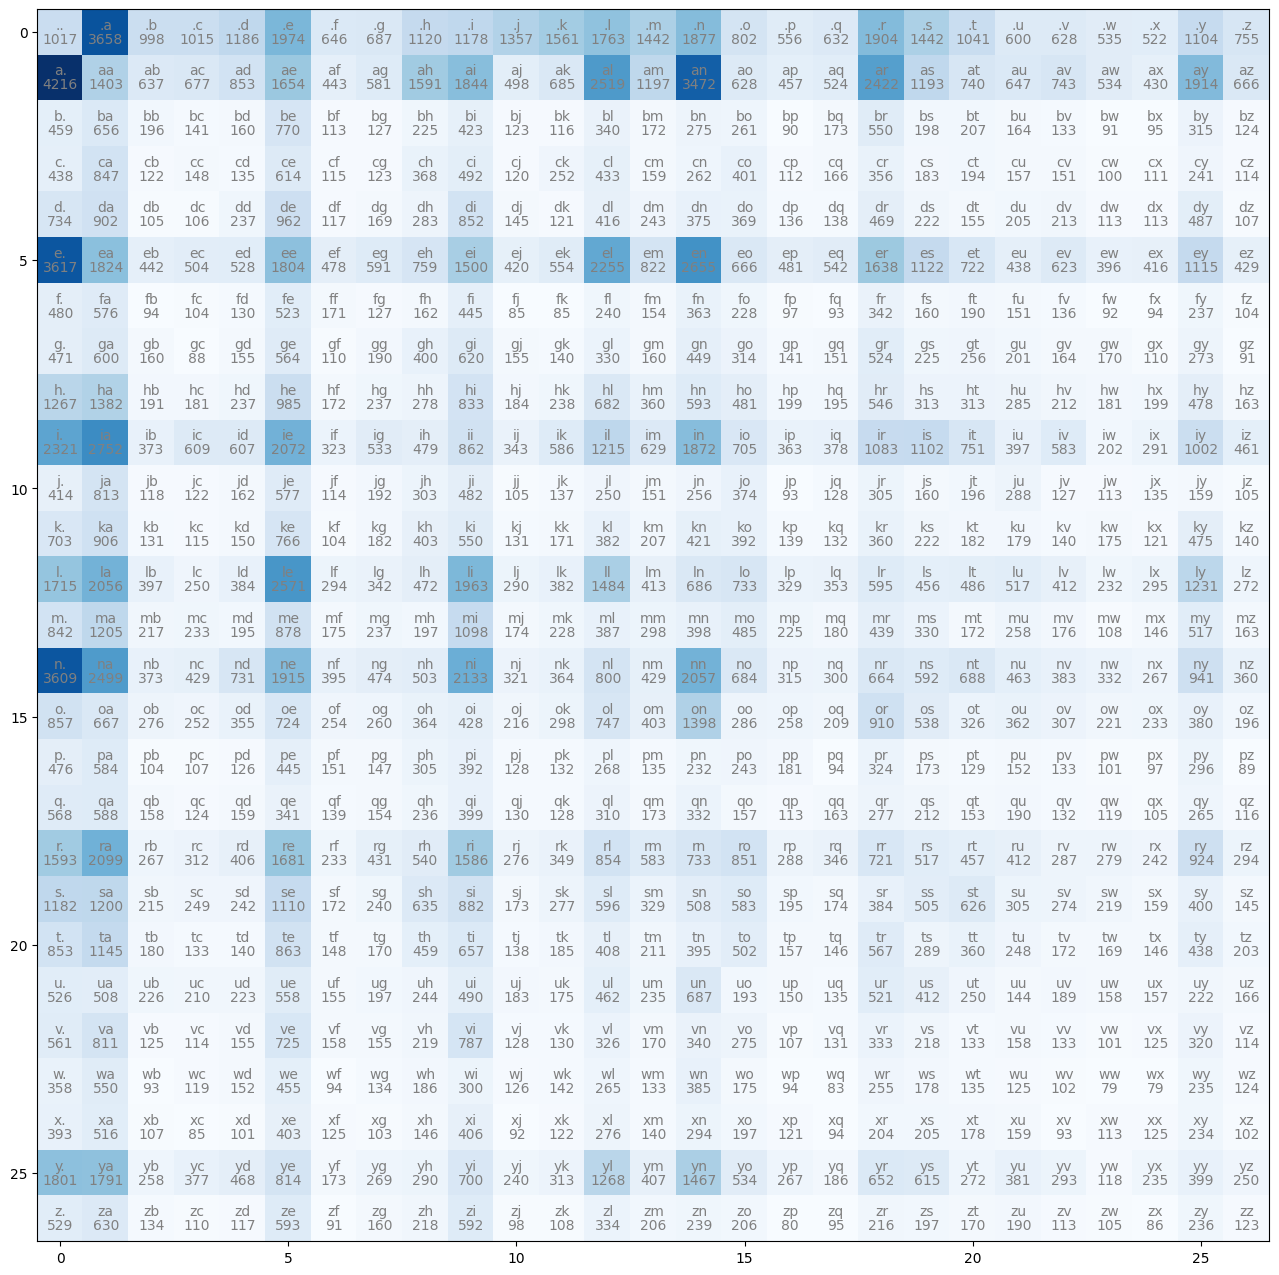

In [13]:
draw_transition_matrix(create_transition_matrix(generated_names))